# Steam Recommendation System
- Tzvi Puchinsky


### Original Data-set
This project is based on the following steam data-set from: 
https://github.com/caserec/Datasets-for-Recommender-Systems/tree/master/Processed%20Datasets/Steam

This data set consist of:
- 200K interaction from 12,393 users on 5,155 games.
- Play hours: 11,350 users and 3,600 games
- Purchase: 12,393 users and 5,155 games

The data set has 4 files:
1. game_purchase.dat - User_ID (int) | Game_ID (int) | Purchase (1) | Total Rows: 129511
2. game_play.dat - User_ID (int) | Game_ID (int) | Hours (float) | Total Rows: 12392
3. item_info.dat - Game_ID (int) | Game Name (string) | Total Rows: 5155
4. user_info.dat - New_ID (int) | Real_ID (int) | Total Rows: 12395

We will be using only the first three files as the real id of the users (user_info) not relevant.

### Extending the data set
To make better results of the planned recommendation system we will be needing more features to found the connection between the purchases and play hours of the users in the data set.
To do so, we will be extending the data set using https://www.igdb.com/ gaming site.
This site provides an API to donwload relevant data using POST messages.

In [1]:
import sys
import os
import json
import requests
import csv
from datetime import datetime
import copy

from vector_class import Vector
from user_vector_class import userVector
from user_vector_data_class import userVectorData

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

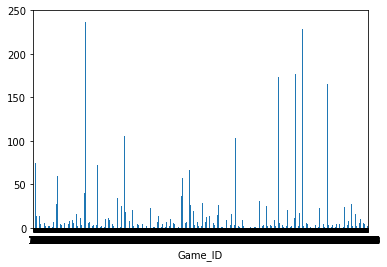

In [3]:
data = pd.read_csv("steamData/game_play.dat", sep='\t')
data = pd.DataFrame(data[['Game_ID','Hours']].groupby('Game_ID').mean())
graph = data['Hours'].plot.bar(x='Game_ID', y='Hours',ylim=(0,250), rot=0)

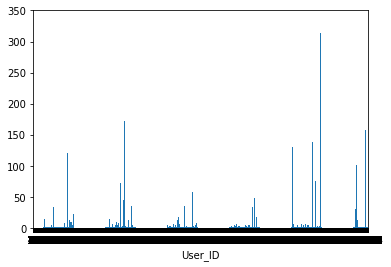

In [4]:
data = pd.read_csv("steamData/game_purchase.dat", sep='\t')
data = pd.DataFrame(data.groupby('User_ID').count())
graph = data['Purchase'].plot.bar(x='User_ID', y='Purchase',ylim=(0,350), rot=0)

**API_KEY** is the key that you get when sign up to the IGDB API. This key is required to make the POST requests to the site and download the required data.

In [5]:
API_KEY = "62cf6f931b24f3128aec27128c0eff1d"

***idgb_request***

Function for making the API request to get data.

**Paramters:**
* api_key : the key that defined before hand as API_KEY.
* endpoint : the endpoint changes depends on the data needed from the site.
* body : the body variants to data needed

**Returns:**
* Json text file from the request

In [6]:
def idgb_request(api_key, endpoint, body):
    # defining the api-endpoint
    API_ENDPOINT = "https://api-v3.igdb.com/" + endpoint

    headers = {'user-key': api_key}
    # body = "fields *; search \"" + game + "\";"

    # sending post request and saving response as response object
    r = requests.post(API_ENDPOINT, data=body, headers=headers)

    return r.text

***download_data_idgb***

Function for downloading all the data that can be reached from the IGDB API.

This function creates directory named "IGDBData" and stores all the data for each game name after making a request to the API. Each game represented with a .txt file withe the game name.

In [7]:
def download_data_idgb():
    files = os.listdir("IGDBData")
    for game in games:
        if game + ".txt" not in files:
            if sys.platform == "darwin" or sys.platform == "linux":
                DirFile = "IGDBData" + "/"
            else:
                DirFile = "IGDBData" + "\""

            # defining the api-endpoint
            API_ENDPOINT = "https://api-v3.igdb.com/games"

            headers = {'user-key': API_KEY}
            body = "fields *; search \"" + game + "\";"

            # sending post request and saving response as response object
            r = requests.post(API_ENDPOINT, data=body, headers=headers)

            game = game.replace("/", "")
            with open(DirFile + game + ".txt", "w") as writer:
                writer.write(r.text)
    print("Finished!")

Loading all the game names from the item_info.dat file to "game" list variable.
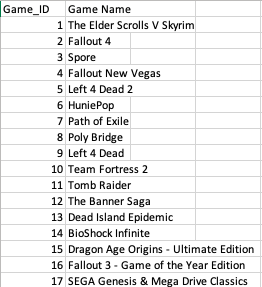

In [8]:
games = list()
with open("steamData/item_info.dat") as file:
    print("Loading data from item_info.dat ...")
    for row in file:
        games.append(row.replace("\n", "").split("\t")[1])
games.pop(0)
# add-on's for jupyter notebook
print("===============")
for i in range(10):
    print(games[i])
print("Total games: {0}".format(len(games)))

Loading data from item_info.dat ...
The Elder Scrolls V Skyrim
Fallout 4
Spore
Fallout New Vegas
Left 4 Dead 2
HuniePop
Path of Exile
Poly Bridge
Left 4 Dead
Team Fortress 2
Total games: 5155


In [9]:
# Checks if IGDBD data dir exists and needs to download data
if not os.path.isdir("IGDBData"):
    download_data_idgb()

### Creating the extended data set file
***create_GameInfoFile***

This function creates the extended data set file that includes the originial steam data and the data gathered via the IDGB API.

The function has two modes that changes by the **readable** var: 
* True (default) - converts all the number data to corresponded string data after creating the enums.
* False - creates the basic data-set files. All the data represented by ID's.

#### Basic Data set
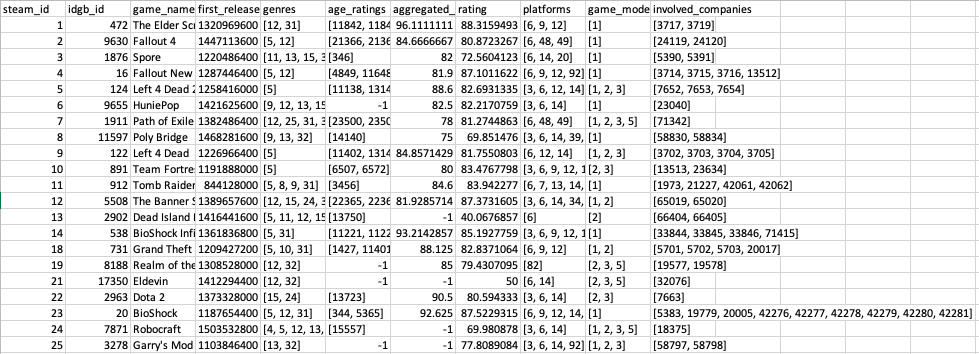

#### Converted Data set
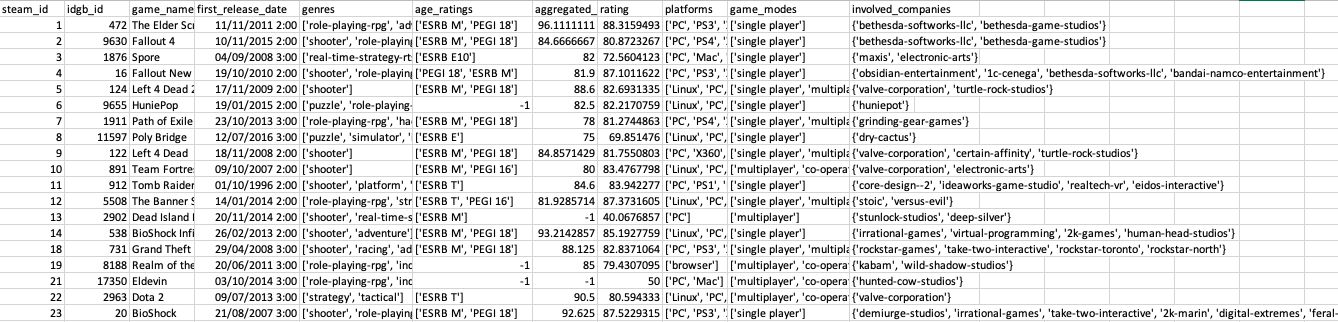

The function has a **force_overwrite** var that dictates if create the file again if one already exists. By default set to **False**.

**file_name** var is set by default  to **"games_info.csv"** this the file that the functions creates. Can be changed but has to be with .csv extension.

All the **enum variables** created by other functions that make the needed requestes to the site and creates the dictionaries required to convert the ID's to strings.


In [10]:
# For Data visualization
data = pd.read_csv("game_info_original.csv")
data

,steam_id,idgb_id,game_name,first_release_date,genres,age_ratings,aggregated_rating,rating,platforms,game_modes,involved_companies
0,1,472,The Elder Scrolls V Skyrim,1320969600,"[12, 31]","[11842, 11843]",96.111111,88.315949,"[6, 9, 12]",[1],"[3717, 3719]"
1,2,9630,Fallout 4,1447113600,"[5, 12]","[21366, 21367]",84.666667,80.872327,"[6, 48, 49]",[1],"[24119, 24120]"
2,3,1876,Spore,1220486400,"[11, 13, 15, 31]",[346],82.000000,72.560412,"[6, 14, 20]",[1],"[5390, 5391]"
3,4,16,Fallout New Vegas,1287446400,"[5, 12]","[4849, 11648]",81.900000,87.101162,"[6, 9, 12, 92]",[1],"[3714, 3715, 3716, 13512]"
4,5,124,Left 4 Dead 2,1258416000,[5],"[11138, 13145]",88.600000,82.693133,"[3, 6, 12, 14]","[1, 2, 3]","[7652, 7653, 7654]"
...,...,...,...,...,...,...,...,...,...,...,...
3820,5151,35200,Warriors & Castles,1435536000,[32],-1,-1.000000,70.000000,"[3, 6]",[2],-1
3821,5152,34575,Romance of the Three Kingdoms Maker,1449532800,"[13, 15]",-1,-1.000000,-1.000000,[6],[1],-1
3822,5153,22248,Space Colony,1430352000,"[13, 15]","[20802, 20803]",77.000000,60.000000,[6],[1],"[60370, 60371]"
3823,5154,34148,Life is Hard,1446508800,"[13, 15, 31, 32]",-1,-1.000000,50.000000,"[3, 6, 14]",[1],[49349]


In [11]:
# For Data visualization
data = pd.read_csv("game_info_update.csv")
data

,steam_id,idgb_id,game_name,first_release_date,genres,rating,platforms,game_modes,involved_companies
0,1,472,The Elder Scrolls V Skyrim,2011,"['role-playing-rpg', 'adventure']",5,"['PC', 'PS3', 'X360']",['single player'],"{'bethesda-softworks-llc', 'bethesda-game-stud..."
1,2,9630,Fallout 4,2015,"['shooter', 'role-playing-rpg']",5,"['PC', 'PS4', 'XONE']",['single player'],"{'bethesda-softworks-llc', 'bethesda-game-stud..."
2,3,1876,Spore,2008,"['real-time-strategy-rts', 'simulator', 'strat...",4,"['PC', 'Mac', 'NDS']",['single player'],"{'maxis', 'electronic-arts'}"
3,4,16,Fallout New Vegas,2010,"['shooter', 'role-playing-rpg']",5,"['PC', 'PS3', 'X360', 'steam']",['single player'],"{'obsidian-entertainment', '1c-cenega', 'bethe..."
4,5,124,Left 4 Dead 2,2009,['shooter'],5,"['Linux', 'PC', 'X360', 'Mac']","['single player', 'multiplayer', 'co-operative']","{'valve-corporation', 'turtle-rock-studios'}"
...,...,...,...,...,...,...,...,...,...
3084,5149,12279,SAMURAI WARRIORS 4-II,2015,['hack-and-slash-beat-em-up'],4,"['PC', 'PS3', 'psn', 'Vita', 'PS4']","['single player', 'multiplayer', 'co-operative']","{'koei-tecmo-games-co-dot-ltd', 'omega-force'}"
3085,5150,15909,The Bug Butcher,2016,"['shooter', 'indie', 'arcade']",4,"['Linux', 'PC', 'Mac', 'PS4', 'XONE']","['single player', 'multiplayer', 'co-operative']",{'awfully-nice-studios'}
3086,5153,22248,Space Colony,2015,"['simulator', 'strategy']",4,['PC'],['single player'],"{'gathering-of-developers', 'firefly-studios'}"
3087,5154,34148,Life is Hard,2015,"['simulator', 'strategy', 'adventure', 'indie']",3,"['Linux', 'PC', 'Mac']",['single player'],{'pirozhok'}


In [12]:
def create_GameInfoFile(platforms_enum, enum_Genres, enum_age_ratings, companies_enum, force_overwrite=False, readable=True, file_name='games_info.csv'):
    enum_GameModes = {1: 'single player', 2: 'multiplayer', 3: 'co-operative', 4: 'split screen', 5: 'MMO'}
    gamesInfo = dict()
    if os.path.isfile(file_name):
        if not force_overwrite:
            while True:
                ans = input("The file " + file_name + " exists. Overwrite? y/n \nAnswer: ")
                if ans == 'y' or ans == 'n':
                    break
            if ans == 'y':
                force_overwrite = True
                print("Force overwrite enabled! " + file_name + " overwritten!")
            else:
                print(file_name + " exists.")
                return
    if not os.path.isfile(file_name) or force_overwrite is True:
        with open(file_name, mode='w') as csv_file:
            fieldsNames = ['steam_id', 'idgb_id', 'game_name', 'first_release_date', 'genres', 'age_ratings',
                           'aggregated_rating', 'rating', 'platforms', 'game_modes', 'involved_companies']
            writer = csv.DictWriter(csv_file, fieldnames=fieldsNames)
            writer.writeheader()
            with open("steamData/item_info.dat") as file:
                for row in file:
                    gamesInfo.clear()  # Reset gamesInfo dict
                    infoTuple = row.replace("\n", "").split("\t")
                    if infoTuple[0] != "Game_ID" and infoTuple[1] != "Game Name":  # ignore the header of the file
                        infoTuple[1] = infoTuple[1].replace("/", "")
                        gamesInfo['steam_id'] = infoTuple[0]
                        gamesInfo['game_name'] = infoTuple[1]
                        with open("IGDBData/" + gamesInfo['game_name'] + ".txt") as jsonData:
                            data = json.load(jsonData)
                            found = False
                            for subData in data:
                                subData['name'] = subData['name'].replace(":", "")
                                if subData['name'].upper() == gamesInfo['game_name'].upper():
                                    found = True
                                    print("Correct Game Dict for {0}".format(gamesInfo['game_name']))
                                    gamesInfo['idgb_id'] = subData.get('id', -1)
                                    timeStamp = subData.get('first_release_date', -1)
                                    if readable:  # converts Unix time stamps to readable Date
                                        if timeStamp != -1:
                                            gamesInfo['first_release_date'] = datetime.fromtimestamp(timeStamp)
                                        else:
                                            gamesInfo['first_release_date'] = timeStamp
                                    else:
                                        gamesInfo['first_release_date'] = timeStamp
                                    genre = subData.get('genres', -1)
                                    if readable:
                                        if genre != -1:
                                            if isinstance(genre, int):
                                                gamesInfo['genres'] = enum_Genres[genre]
                                            else:
                                                for i in range(len(genre)):
                                                    genre[i] = enum_Genres[genre[i]]
                                                gamesInfo['genres'] = genre
                                        else:
                                            gamesInfo['genres'] = genre
                                    else:
                                        gamesInfo['genres'] = genre
                                    age = subData.get('age_ratings', -1)
                                    if readable:
                                        if age != -1:
                                            if isinstance(age, int):
                                                gamesInfo['age_ratings'] = enum_age_ratings[age]
                                            else:
                                                for i in range(len(age)):
                                                    age[i] = enum_age_ratings[age[i]]
                                                gamesInfo['age_ratings'] = age
                                        else:
                                            gamesInfo['age_ratings'] = age
                                    else:
                                        gamesInfo['age_ratings'] = age
                                    gamesInfo['rating'] = subData.get('rating', -1)
                                    gamesInfo['aggregated_rating'] = subData.get('aggregated_rating', -1)
                                    platforms = subData.get('platforms', -1)
                                    if readable:
                                        if platforms != -1:
                                            if isinstance(platforms, int):
                                                gamesInfo['platforms'] = platforms_enum[platforms]
                                            else:
                                                for i in range(len(platforms)):
                                                    platforms[i] = platforms_enum[platforms[i]]
                                                gamesInfo['platforms'] = platforms
                                        else:
                                            gamesInfo['platforms'] = platforms
                                    else:
                                        gamesInfo['platforms'] = platforms
                                    gameModes = subData.get('game_modes', -1)
                                    if readable:  # Converts Game modes
                                        if gameModes != -1:
                                            for i in range(len(gameModes)):
                                                gameModes[i] = enum_GameModes[gameModes[i]]
                                            gamesInfo['game_modes'] = gameModes
                                        else:
                                            gamesInfo['game_modes'] = gameModes
                                    else:
                                        gamesInfo['game_modes'] = gameModes
                                    companies = subData.get('involved_companies', -1)
                                    if readable:
                                        if companies != -1:
                                            if isinstance(companies, int):
                                                gamesInfo['involved_companies'] = companies_enum[companies]
                                            else:
                                                for i in range(len(companies)):
                                                    companies[i] = companies_enum[companies[i]]
                                                gamesInfo['involved_companies'] = set(companies)
                                        else:
                                            gamesInfo['involved_companies'] = companies
                                    else:
                                        gamesInfo['involved_companies'] = companies
                                    writer.writerow(gamesInfo)
                                    break
                            if not found:
                                print("[!!] No dict found for {0}".format(gamesInfo['game_name']))

Creates a csv file named enum_Platforms.csv that contains all the keys and names of platforms.<br> For better understanding of the data set.<Br>The data is gathered via post request to the IDGB site.

***:return:*** enum_Platforms dict

In [13]:
def create_platform_enum():
    """
    Creates a csv file named enum_Platforms.csv that contains all the keys and names of platforms
    For better understanding of the data set.
    The data is gathered via post request to the IDGB site.
    :return: enum_Platforms dict
    """
    if not os.path.isfile("enum_Platforms.csv"):
        enum_Platforms = dict()
        with open("games_info.csv", mode='r') as csv_read:
            reader = csv.DictReader(csv_read)
            for line in reader:
                currentPlatforms = line['platforms']
                currentPlatformsList = json.loads(currentPlatforms)
                if isinstance(currentPlatformsList, int):
                    if enum_Platforms.get(plat) is None:  # Checks if key exists in dict
                        body = 'fields *; where id = ' + str(plat) + ';'
                        ans = idgb_request(API_KEY, 'platforms', body)
                        json_ans = json.loads(ans)
                        enum_Platforms[plat] = json_ans[0]['abbreviation']
                        print(enum_Platforms)
                else:
                    for plat in currentPlatformsList:
                        if enum_Platforms.get(plat) is None:  # Checks if key exists in dict
                            body = 'fields *; where id = ' + str(plat) + ';'
                            ans = idgb_request(API_KEY, 'platforms', body)
                            json_ans = json.loads(ans)
                            try:
                                enum_Platforms[plat] = json_ans[0]['abbreviation']
                            except KeyError:
                                enum_Platforms[plat] = json_ans[0]['name']
                            print(enum_Platforms)

        with open("enum_Platforms.csv", mode='w') as csv_write:
            enum_writer = csv.writer(csv_write, delimiter=',')

            for key in enum_Platforms.keys():
                enum_writer.writerow([key, enum_Platforms[key]])

        return enum_Platforms
    else:
        enum_Platforms = dict()
        with open("enum_Platforms.csv", mode='r') as csv_read:
            reader = csv.reader(csv_read, delimiter=',')
            for line in reader:
                enum_Platforms[int(line[0])] = line[1]
        return enum_Platforms

Global function for creating basic enums.
<br>Parameters:<br>
* file_name - the csv file name to be created.
* enum_name - the enum that needed ex. "platforms", this enum_name acts as the endpoint for the API.
* args - the specific data the needes to be extracted from the request answer.

In [14]:
def create_enum(file_name, enum_name, args):
    if not os.path.isfile(file_name + ".csv"):
        enum = dict()
        with open("games_info.csv", mode='r') as csv_read:
            reader = csv.DictReader(csv_read)
            for line in reader:
                currentPlatforms = line[enum_name]
                currentPlatformsList = json.loads(currentPlatforms)
                if isinstance(currentPlatformsList, int):  # Checks if there is only one value than its int, not list of ints
                    if enum.get(plat) is None:  # Checks if key exists in dict
                        body = 'fields *; where id = ' + str(plat) + ';'
                        ans = idgb_request(API_KEY, enum_name, body)
                        json_ans = json.loads(ans)
                        enum[plat] = json_ans[0][args[0]]
                        print(enum)
                else:
                    for plat in currentPlatformsList:
                        if enum.get(plat) is None:  # Checks if key exists in dict
                            body = 'fields *; where id = ' + str(plat) + ';'
                            ans = idgb_request(API_KEY, enum_name, body)
                            json_ans = json.loads(ans)
                            try:
                                enum[plat] = json_ans[0][args[0]]
                            except KeyError:
                                enum[plat] = json_ans[0][args[1]]
                            print(enum)

        with open(file_name + ".csv", mode='w') as csv_write:
            enum_writer = csv.writer(csv_write, delimiter=',')

            for key in enum.keys():
                enum_writer.writerow([key, enum[key]])

        return enum
    else:
        enum = dict()
        with open(file_name + ".csv", mode='r') as csv_read:
            reader = csv.reader(csv_read, delimiter=',')
            for line in reader:
                enum[int(line[0])] = line[1]
        return enum

##### Converting age ratings
The age ratings at the IGDB site uses catogeries for <a href="https://www.esrb.org/ratings-guide/">ESRB</a> and <a href="https://pegi.info/">PEGI</a> ratings.
<br> This functions uses pre-defined enums to categorized the ratings. 

In [15]:
def convert_age_ratings(file_name):
    age_ratings_category = {1: 'ESRB', 2: 'PEGI'}
    age_ratings_rating = {1: '3', 2: '7', 3: '12', 4: '16', 5: '18', 6: 'RP', 7: 'EC', 8: 'E', 9: 'E10', 10: 'T',
                          11: 'M', 12: 'AO'}
    if not os.path.isfile(file_name + '.csv'):
        enum = dict()
        with open("games_info.csv", mode='r') as csv_read:
            reader = csv.DictReader(csv_read)
            for line in reader:
                current_rating = json.loads(line['age_ratings'])
                if current_rating != -1:
                    if isinstance(current_rating, int):
                        if enum.get(current_rating) is None:
                            body = 'fields *; where id = ' + str(current_rating) + ';'
                            ans = idgb_request(API_KEY, 'age_ratings', body)
                            json_ans = json.loads(ans)
                            category = age_ratings_category[json_ans['category']]
                            rating = age_ratings_rating[json_ans['rating']]
                            enum[current_rating] = category + " " + rating
                            print(enum)
                    else:
                        for rating in current_rating:
                            if enum.get(rating) is None:
                                body = 'fields *; where id = ' + str(rating) + ';'
                                ans = idgb_request(API_KEY, 'age_ratings', body)
                                json_ans = json.loads(ans)
                                category = age_ratings_category[json_ans[0]['category']]
                                rating_value = age_ratings_rating[json_ans[0]['rating']]
                                enum[rating] = category + " " + rating_value
                                print(enum)

        with open(file_name + ".csv", mode='w') as csv_write:
            enum_writer = csv.writer(csv_write, delimiter=',')

            for key in enum.keys():
                enum_writer.writerow([key, enum[key]])

        return enum
    else:
        enum = dict()
        with open(file_name + ".csv", mode='r') as csv_read:
            reader = csv.reader(csv_read, delimiter=',')
            for line in reader:
                enum[int(line[0])] = line[1]
        return enum

##### Convert company ID's
This function creates the company enum. This function differes from the other enum functions because of the data structure.
<br> To get the company name that created the specific game in question the function needes to query the api twice.

In [16]:
def create_company_enum(file_name):
    enum_comp_id = dict()
    enum_comp_name = dict()
    total_enum = dict()
    if not os.path.isfile(file_name + '.csv'):
        if not os.path.isfile(file_name + "_IDs.csv"):
            with open("games_info.csv", mode='r') as csv_read:
                reader = csv.DictReader(csv_read)
                for line in reader:
                    current_companies = json.loads(line['involved_companies'])
                    if current_companies != -1:
                        if isinstance(current_companies, int):
                            if enum_comp_id.get(current_companies) is None:
                                body = 'fields *; where id = ' + str(current_companies) + ';'
                                ans = idgb_request(API_KEY, 'involved_companies', body)
                                json_ans = json.loads(ans)
                                enum_comp_id[current_companies] = int(json_ans[0]['company'])
                                print(enum_comp_id)
                        else:
                            for comp in current_companies:
                                if enum_comp_id.get(comp) is None:
                                    body = 'fields *; where id = ' + str(comp) + ';'
                                    ans = idgb_request(API_KEY, 'involved_companies', body)
                                    json_ans = json.loads(ans)
                                    enum_comp_id[comp] = json_ans[0]['company']
                                    print(enum_comp_id)

            with open(file_name + "_IDs.csv", mode='w') as csv_write:
                enum_writer = csv.writer(csv_write, delimiter=',')

                for key in enum_comp_id.keys():
                    enum_writer.writerow([key, enum_comp_id[key]])

        with open(file_name + "_IDs.csv", mode='r') as csv_read:
            reader = csv.reader(csv_read, delimiter=',')
            for line in reader:
                enum_comp_id[int(line[0])] = int(line[1])

        for key in enum_comp_id.keys():
            if enum_comp_name.get(enum_comp_id[key]) is None:
                body = 'fields *; where id = ' + str(enum_comp_id[key]) + ';'
                ans = idgb_request(API_KEY, 'companies', body)
                json_ans = json.loads(ans)
                try:
                    enum_comp_name[enum_comp_id[key]] = json_ans[0]['slug']
                except KeyError:
                    enum_comp_name[enum_comp_id[key]] = json_ans[0]['name']
                print(enum_comp_name)

        with open(file_name + ".csv", mode='w') as csv_write:
            enum_writer = csv.writer(csv_write, delimiter=',')

            for key in enum_comp_name.keys():
                enum_writer.writerow([key, enum_comp_name[key]])

        for key in enum_comp_id.keys():
            total_enum[key] = enum_comp_name[enum_comp_id[key]]
    else:
        with open(file_name + "_IDs.csv", mode='r') as csv_read:
            reader = csv.reader(csv_read, delimiter=',')
            for line in reader:
                enum_comp_id[int(line[0])] = int(line[1])

        with open(file_name + ".csv", mode='r') as csv_read:
            reader = csv.reader(csv_read, delimiter=',')
            for line in reader:
                enum_comp_name[int(line[0])] = line[1]

        for key in enum_comp_id.keys():
            total_enum[key] = enum_comp_name[enum_comp_id[key]]
    return total_enum

#### Pre-process
Currently this function just removes the lines of data that does not contain any data.
<br> Each cell that is empty marked with -1. The function counts number of -1 in each line, if line contains **max_empty_cells**, skips the current line.
<br> ***Returns***:
* data_set - list type var with all the data after removing empty lines.
* header_enum - dict type enum with header names for further simple access to the list.

In [17]:
def missing_lines_remove(file_name, max_empty_cells=8):
    if os.path.isfile(file_name):
        data_set = list()
        with open(file_name, mode='r') as csv_read:
            reader = csv.reader(csv_read)
            for line in reader:
                if line[0] == "steam_id":
                    header_enum = dict()
                    enum_header = dict()
                    for i in range(len(line)):
                        header_enum[line[i]] = i
                        enum_header[i] = line[i]
                    continue
                count = 0
                for cell in line:
                    if cell == '-1':
                        count = count + 1
                if count >= max_empty_cells:
                    continue
                else:
                    data_set.append(line)
        return data_set, header_enum, enum_header

    else:
        print("Error!! No " + file_name + " exists! Cant continue")
        exit(0)

#### Creating enums
Creating enums for convertion using the previously defined functions.

In [18]:
enum_companies = create_company_enum("enum_Companies")
enum_Age_ratings = convert_age_ratings("enum_Age_Ratings")
enum_genres = create_enum("enum_Genres", "genres", ['slug', 'name'])
enum_Platforms = create_platform_enum()

In [19]:
pd.DataFrame.from_dict(enum_companies, orient="index").head()

,0
3717,bethesda-softworks-llc
3719,bethesda-game-studios
24119,bethesda-softworks-llc
24120,bethesda-game-studios
5390,maxis


In [20]:
pd.DataFrame.from_dict(enum_Age_ratings, orient="index").head()

,0
11842,ESRB M
11843,PEGI 18
21366,ESRB M
21367,PEGI 18
346,ESRB E10


In [21]:
pd.DataFrame.from_dict(enum_genres, orient="index").head()

,0
12,role-playing-rpg
31,adventure
5,shooter
11,real-time-strategy-rts
13,simulator


In [22]:
pd.DataFrame.from_dict(enum_Platforms, orient="index").head()

,0
6,PC
9,PS3
12,X360
48,PS4
49,XONE


In [23]:
create_GameInfoFile(enum_Platforms, enum_genres, enum_Age_ratings, enum_companies)

#### Print Stats function
This function was created to calculate stats of the data each time we reomve lines by the number of missing data (-1). <br>
This function shows the number of missing data and the precentage of the data as follows:
<br>Number of missing lines / Total missing lines | Precentage: %

In [24]:
def print_stats(data, header):
    stats = dict()
    for i in range(len(header)):
        stats[i] = 0
    total = len(data)
    for i in range(len(header)):
        for line in data:
            if line[i] == '-1':
                stats[i] += 1
    stats2 = dict()
    for key in stats.keys():
        stats2[header[key]] = stats[key]
    stats.clear()
    print("Number of missing values in current data set: ")
    for key in stats2.keys():
        print("{0} : {1}/{2} | Percentage : {3:2.2f}%".format(key, stats2[key], total, stats2[key]/total*100))

#### Pre-process of missing lines
These part of the pre processing decisions of how much data we need to remove and still have enough data to work and process. <br>
In this section we run each time another value for missing values in each line and evaluate the results.

In [25]:
for i in range(1, 9):
    print("Pre-process for {0}".format(i))
    data_set, header_enum, enum_header = missing_lines_remove('games_info.csv', i)
    print_stats(data_set, enum_header)
    print("================================================")

Pre-process for 1
Number of missing values in current data set: 
steam_id : 0/1187 | Percentage : 0.00%
idgb_id : 0/1187 | Percentage : 0.00%
game_name : 0/1187 | Percentage : 0.00%
first_release_date : 0/1187 | Percentage : 0.00%
genres : 0/1187 | Percentage : 0.00%
age_ratings : 0/1187 | Percentage : 0.00%
aggregated_rating : 0/1187 | Percentage : 0.00%
rating : 0/1187 | Percentage : 0.00%
platforms : 0/1187 | Percentage : 0.00%
game_modes : 0/1187 | Percentage : 0.00%
involved_companies : 0/1187 | Percentage : 0.00%
Pre-process for 2
Number of missing values in current data set: 
steam_id : 0/1989 | Percentage : 0.00%
idgb_id : 0/1989 | Percentage : 0.00%
game_name : 0/1989 | Percentage : 0.00%
first_release_date : 0/1989 | Percentage : 0.00%
genres : 0/1989 | Percentage : 0.00%
age_ratings : 430/1989 | Percentage : 21.62%
aggregated_rating : 342/1989 | Percentage : 17.19%
rating : 22/1989 | Percentage : 1.11%
platforms : 0/1989 | Percentage : 0.00%
game_modes : 3/1989 | Percentage 

#### Evaluating the results
We can see that the best argument for removal is 3. <br>
We still get enough data and the number of missing values can be filled manually in reasonable time.

In [26]:
print("The chosen max empty cells is 3 as its best fit. \nAnd age_ratings & aggregated_rating is removed due to high percentage of missing data")
data_set, header_enum, enum_header = missing_lines_remove('games_info.csv', 3)

The chosen max empty cells is 3 as its best fit. 
And age_ratings & aggregated_rating is removed due to high percentage of missing data


#### Rating binning
This function is part of the pre-process. <br>
We want to split the values of the rating to minimize the feature length of the rating feature.<br>
The binning is as follows:
- 0 <= value < 20 = 1
- 20 <= value < 40 = 2
- 40 <= value < 60 = 3
- 60 <= value < 80 = 4
- 80 <= value < 90 = 5
- 90 <= value <= 100 = 6
- Other sets to 9

In [27]:
def rating_binning(value):
    val = float(value)
    if 0 <= val < 20:
        return 1
    elif 20 <= val < 40:
        return 2
    elif 40 <= val < 60:
        return 3
    elif 60 <= val < 80:
        return 4
    elif 80 <= val < 90:
        return 5
    elif 90 <= val <= 100:
        return 6
    else:
        return 9

#### Continue the pre-process
1. Convert all the dates to jsut Year values (strings)
2. Categiruze the rating values using the rating_binning funciton.
3. Remove the "age_ratings" column as conclusion of the stats function.
4. Remove the aggregated_rating column as conclusion of the stats function.

In [28]:
for line in data_set:
    line[3] = line[3][6:10]  # Convert all the dates to just Year value (strings)
    line[7] = str(rating_binning(line[7]))  # Categorize the rating value
    line.pop(5)  # Remove the age_ratings column
    line.pop(5)  # Remove the aggregated_rating column

#### Creating game_info_update
Creating the new game_info.csv file after converting all the values.

In [29]:
header = list()
for key in header_enum:
    header.append(key)
header.pop(5)
header.pop(5)
with open("game_info_update.csv", mode='w') as update:
    updateWriter = csv.writer(update, delimiter=',', quotechar='"')
    updateWriter.writerow(header)
    for line in data_set:
        updateWriter.writerow(line)

#### Creating the base vector
Using the updated file that filled the empty spaces manually to get full data. <br>
Creating sets of values for the features values of the vector.

In [30]:
with open("backupData/game_info_update.csv", mode='r') as update2:
    first_release_date = list()
    genres = list()
    platforms = list()
    game_mode = list()
    companies = list()

    updateReader = csv.DictReader(update2)
    for line in updateReader:
        first_release_date.append(line['first_release_date'])
        # Genre Column
        genre = json.loads(line['genres'].replace('\'', '"'))
        if isinstance(genre, list):
            for g in genre:
                genres.append(g)
        else:
            genres.append(genre)

        # Platforms Column
        plat = json.loads(line['platforms'].replace('\'', '"'))
        if isinstance(plat, list):
            for g in plat:
                platforms.append(g)
        else:
            platforms.append(plat)

        # Game Mode Column
        game = json.loads(line['game_modes'].replace('\'', '"'))
        if isinstance(game, list):
            for g in game:
                game_mode.append(g)
        else:
            game_mode.append(game)

        # Companies Column
        comp = json.loads(line['involved_companies'].replace('\'', '"').replace('{', '[').replace('}', ']'))
        if isinstance(comp, list):
            for g in comp:
                companies.append(g)
        else:
            companies.append(comp)

    first_release_date = set(first_release_date)
    genres = set(genres)
    platforms = set(platforms)
    game_mode = set(game_mode)
    companies = set(companies)

## Creating Base Vector

In [31]:
vector = dict()
for item in first_release_date:
    vector[item] = 0
for item in genres:
    vector[item] = 0
for i in range(1, 7):
    vector[str(i)] = 0
vector[str(9)] = 0
for item in platforms:
    vector[item] = 0
for item in game_mode:
    vector[item] = 0
for item in companies:
    vector[item] = 0

#### Creating the vector csv
This funciton creats the vector.csv files that neede afterwards for calculations. <br>
- cur_vector - The vector data
- filename - the file name ex. user_vector.csv
- enabled - set to default for True, if set to false disable the funciton

In [32]:
def create_Vector_csv(cur_vector, filename, enabled=True):
    if enabled:
        curDict = dict()
        headlines = list()
        if isinstance(cur_vector, Vector):
            curDict = cur_vector.vectorDict
        elif isinstance(cur_vector, userVector):
            curDict = cur_vector.objDict
        else:
            print("ERROR while creating vector csv. Shut Down")
            exit(0)
        for vecKey in curDict.keys():
            headlines.append(vecKey)
        if not os.path.isfile("Vectors_data/" + filename + ".csv"):
            with open("Vectors_data/" + filename + ".csv", mode='w') as vectorFile:
                vectorFileWriter = csv.DictWriter(vectorFile, fieldnames=headlines)

                vectorFileWriter.writeheader()
                vectorFileWriter.writerow(curDict)
        else:
            with open("Vectors_data/" + filename + ".csv", mode='a') as vectorFile:
                vectorFileWriter = csv.DictWriter(vectorFile, fieldnames=headlines)
                vectorFileWriter.writerow(curDict)

In [33]:
def checkLine(line):
    for item in line:
        if line[item] == '-1' or line[item] == -1:
            return False
    return True

##### Clear Vector
Clear the vector data and sets all the values to 0

In [34]:
def clearVector(vec):
    if -1 in vec:
        vec.pop(-1)
    for ckey in vec.keys():
        vec[ckey] = 0
    return vec

## Creating the game vectors
This part of the code creates the game vectors and using the creat csv funciton to write the data to the file locally for usage afterwards. And so that we will not need to calculate the data again if already calculated beforehand.<br>
Using the **Vector Class** <br>
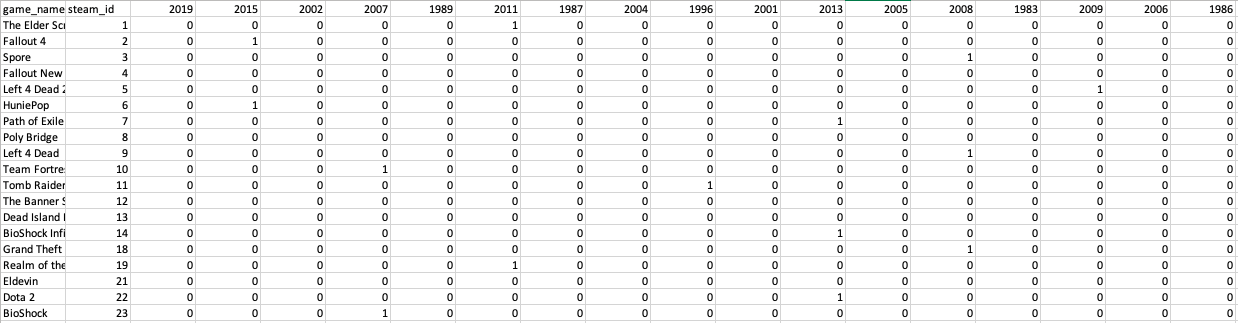

In [35]:
# For jupyter notebook
data = pd.read_csv("Vectors_data/game_vector.csv")
data

,game_name,steam_id,1987,1993,1994,2014,1989,2009,1997,1990,...,ea-games-duplicate,robotality,teedoubleu,hitcents,esp-software,choice-of-games,digital-scapes-studios,nixxes-software,out-of-the-park-developments,doctor-entertainment
0,The Elder Scrolls V Skyrim,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fallout 4,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Spore,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fallout New Vegas,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Left 4 Dead 2,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,SAMURAI WARRIORS 4-II,5149,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3085,The Bug Butcher,5150,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3086,Space Colony,5153,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3087,Life is Hard,5154,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
%%capture 
# %%capture - Jupyter funciton to disable output priniting of the cell
VectorDict = dict() # All game vectors
with open("backupData/game_info_update.csv", mode='r') as info:
    info_reader = csv.DictReader(info)
    for line in info_reader:
        print(line)
        if not checkLine(line):
            continue
        new_vector = Vector(clearVector(vector))
        new_vector.gameSteamID = int(line['steam_id'])
        new_vector.gameName = line['game_name']
        # == Vector data ==
        # First release date
        new_vector.vectorValues[line['first_release_date']] = 1
        # Genres
        genre = json.loads(line['genres'].replace('\'', '"'))
        if isinstance(genre, list):
            for g in genre:
                new_vector.vectorValues[g] = 1
        else:
            new_vector.vectorValues[genre] = 1
        # Rating
        new_vector.vectorValues[line['rating']] = 1
        # Platforms
        plat = json.loads(line['platforms'].replace('\'', '"'))
        if isinstance(plat, list):
            for g in plat:
                new_vector.vectorValues[g] = 1
        else:
            new_vector.vectorValues[plat] = 1
        # Game Modes
        game = json.loads(line['game_modes'].replace('\'', '"'))
        if isinstance(game, list):
            for g in game:
                new_vector.vectorValues[g] = 1
        else:
            new_vector.vectorValues[game] = 1
        # Companies
        comp = json.loads(line['involved_companies'].replace('\'', '"').replace('{', '[').replace('}', ']'))
        if isinstance(comp, list):
            for g in comp:
                new_vector.vectorValues[g] = 1
        else:
            new_vector.vectorValues[comp] = 1

        new_vector.create_full_dict()
        create_Vector_csv(new_vector, "game_vector", False)
        VectorDict[new_vector.gameSteamID] = copy.deepcopy(new_vector)# Has to be deepcopy or else the same reference changes

## Creating user vectors
This part of the code takes all the games that each user purchsed as specified in the game_purchase.dat file and calculates the user vector by combining all the data collected to one specific vector to represent each user. <br>
Using the **userVector Class** <br>
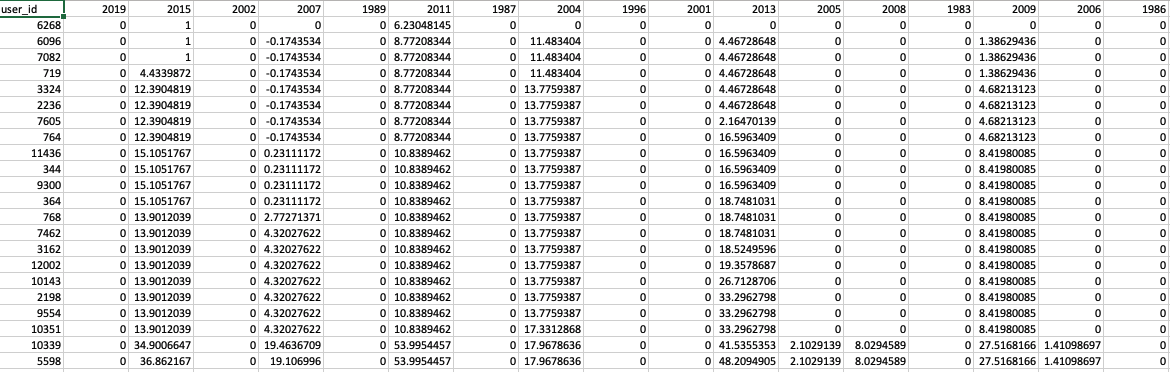

In [37]:
# For jupyter
data = pd.read_csv("Vectors_data/user_vector.csv")
data

,user_id,1997,2000,2013,2018,1996,1998,2006,2012,1983,...,amaranth-games,blit-software,house-of-tales,unknown-worlds,asobo-studio,kittehface-software,pandemic-studios,supermassive-games,cbs-studios,lonely-troops
0,7565,0.0,0.0,-0.798508,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4278,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9554,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.931826,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11424,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8512,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12388,4765,0.0,0.0,2.302585,0.0,0.0,0.0,0.0,6.146329,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12389,9095,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12390,4913,0.0,0.0,16.046535,0.0,0.0,0.0,0.0,15.637907,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12391,1848,0.0,0.0,3.332205,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
userVectors = dict()
if not os.path.isfile("Vectors_data/user_vector.csv") or False:
    counter, total = 0, len(user_ids)
    for id_user in user_ids:
        usr = userVector(id_user, vector)
        print("Calculating vector {0}".format(usr))
        usr.calculateUserVector(VectorDict)
        usr.createObjDir()
        create_Vector_csv(usr, "user_vector", True)
        userVectors[id_user] = copy.deepcopy(usr)
        print("Progress: {0}/{1}".format(counter, total))
        counter += 1